# ETH fee gas price median prediction using glass node tier 1 metrics

## Load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("input/eth_data.csv")

In [2]:
df.transactions_size_mean.value_counts()

0.0    2108
Name: transactions_size_mean, dtype: int64

In [3]:
df.transactions_size_sum.value_counts()

0.0    2108
Name: transactions_size_sum, dtype: int64

In [4]:
# drop fees_gas_price_mean because the attribute to be predicted is fees_gas_price_median
# drop transactions_size_mean and transactions_size_sum since they only contain 0 values
drop_cols = ["date", "fees_gas_price_mean", "transactions_size_mean", "transactions_size_sum"]
df.drop(drop_cols, axis=1, inplace=True)

In [5]:
# no non_null values
# only numeric values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2108 entries, 0 to 2107
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   addresses_count                       2108 non-null   int64  
 1   addresses_sending_count               2108 non-null   int64  
 2   addresses_receiving_count             2108 non-null   int64  
 3   addresses_active_count                2108 non-null   int64  
 4   addresses_new_non_zero_count          2108 non-null   int64  
 5   mining_difficulty_mean                2108 non-null   float64
 6   mining_difficulty_latest              2108 non-null   int64  
 7   mining_hash_rate_mean                 2108 non-null   float64
 8   transactions_count                    2108 non-null   float64
 9   transactions_rate                     2108 non-null   float64
 10  transactions_transfers_count          2108 non-null   float64
 11  transactions_tran

In [6]:
df.describe()

,addresses_count,addresses_sending_count,addresses_receiving_count,addresses_active_count,addresses_new_non_zero_count,mining_difficulty_mean,mining_difficulty_latest,mining_hash_rate_mean,transactions_count,transactions_rate,...,transactions_transfers_volume_median,fees_gas_used_sum,fees_gas_used_mean,fees_gas_used_median,fees_gas_limit_tx_mean,fees_gas_limit_tx_median,fees_gas_price_median,fees_volume_sum,fees_volume_mean,indicators_sopr
count,2.108000e+03,2108.000000,2108.000000,2108.000000,2108.000000,2.108000e+03,2.108000e+03,2.108000e+03,2.108000e+03,2108.000000,...,2108.000000,2.108000e+03,2108.000000,2108.000000,2108.000000,2108.000000,2.108000e+03,2108.000000,2108.000000,2108.000000
mean,3.608834e+07,96424.099146,138105.467268,218137.833017,55184.925047,1.937266e+15,1.948696e+15,1.355472e+14,5.213232e+05,6.033834,...,0.566588,3.351110e+10,54623.657171,27048.507116,166189.536813,76394.999051,3.267841e+10,1738.639381,0.002128,0.996462
std,3.452723e+07,81041.125077,108672.027306,171333.304468,51658.164021,1.583882e+15,1.596792e+15,1.164163e+14,4.033135e+05,4.667980,...,0.960252,2.733464e+10,16951.427410,7536.332935,55555.926913,18549.687761,4.256520e+10,3869.932564,0.003079,0.129518
min,1.028800e+04,457.000000,439.000000,731.000000,44.000000,1.470839e+12,1.531935e+12,8.827049e+10,1.312000e+03,0.015185,...,0.000000,3.886300e+07,22032.696751,21000.000000,45679.056098,22000.000000,1.200000e+09,5.507452,0.000373,0.360587
25%,7.612025e+05,9800.250000,18818.500000,20783.000000,2764.250000,1.040546e+14,1.049934e+14,7.291593e+12,4.973275e+04,0.575611,...,0.100289,2.030627e+09,38935.664982,21000.000000,131827.820713,65000.000000,1.000000e+10,54.923599,0.000687,0.961995
50%,3.399438e+07,92238.500000,140424.000000,230047.500000,48254.000000,2.202665e+15,2.205370e+15,1.530092e+14,5.597435e+05,6.478513,...,0.174072,3.774507e+10,56864.558224,22392.000000,158545.047374,80000.000000,2.000000e+10,391.475712,0.000890,1.006938
75%,6.260956e+07,139538.250000,202224.000000,331295.500000,83019.750000,2.975433e+15,2.999744e+15,2.054996e+14,7.771410e+05,8.994687,...,1.002248,4.744492e+10,67175.989488,34105.000000,198694.280800,90000.000000,4.400000e+10,753.429050,0.001925,1.037700
max,1.163396e+08,444027.000000,595595.000000,794922.000000,348434.000000,7.886198e+15,8.215645e+15,5.908259e+14,1.632453e+06,18.894132,...,18.977734,9.644762e+10,206886.047017,87179.000000,890603.044116,300000.000000,5.440000e+11,42763.252558,0.032143,2.391537


## Split data

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

## Look at training set

In [8]:
# correlation matrix
corr_mat = train_set.corr()
# sort corr_mat in an descending order
sorted_corr = corr_mat["fees_gas_price_median"].sort_values(ascending=False)
top_5_corr_att = list(sorted_corr.iloc[0:6].index)

<AxesSubplot:>

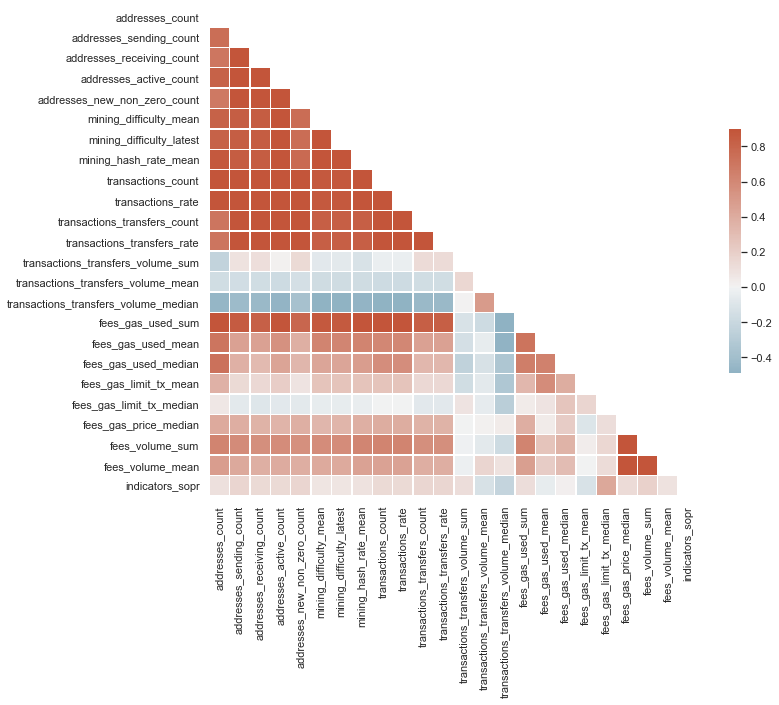

In [9]:
# Plotting diagonal correlation matrix

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

array([[<AxesSubplot:xlabel='fees_gas_price_median', ylabel='fees_gas_price_median'>,
        <AxesSubplot:xlabel='fees_volume_sum', ylabel='fees_gas_price_median'>,
        <AxesSubplot:xlabel='fees_volume_mean', ylabel='fees_gas_price_median'>,
        <AxesSubplot:xlabel='addresses_count', ylabel='fees_gas_price_median'>,
        <AxesSubplot:xlabel='transactions_count', ylabel='fees_gas_price_median'>,
        <AxesSubplot:xlabel='transactions_rate', ylabel='fees_gas_price_median'>],
       [<AxesSubplot:xlabel='fees_gas_price_median', ylabel='fees_volume_sum'>,
        <AxesSubplot:xlabel='fees_volume_sum', ylabel='fees_volume_sum'>,
        <AxesSubplot:xlabel='fees_volume_mean', ylabel='fees_volume_sum'>,
        <AxesSubplot:xlabel='addresses_count', ylabel='fees_volume_sum'>,
        <AxesSubplot:xlabel='transactions_count', ylabel='fees_volume_sum'>,
        <AxesSubplot:xlabel='transactions_rate', ylabel='fees_volume_sum'>],
       [<AxesSubplot:xlabel='fees_gas_price_median

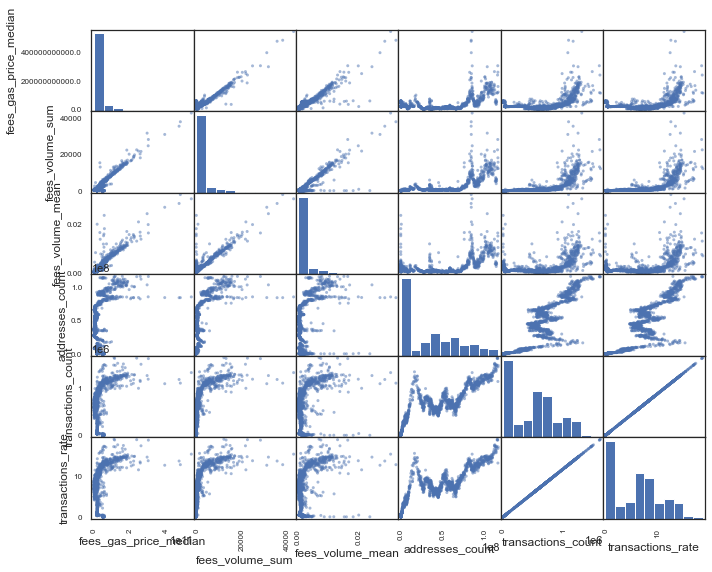

In [10]:
from pandas.plotting import scatter_matrix
# only plot scatter matrix for the top 5 correlated attributes
scatter_matrix(train_set[top_5_corr_att], figsize=(11, 9))

## Preprocessing

In [11]:
# separate data and label
X_train = train_set.drop("fees_gas_price_median", axis=1)
y_train = train_set["fees_gas_price_median"].copy()

X_test = test_set.drop("fees_gas_price_median", axis=1)
y_test = test_set["fees_gas_price_median"].copy() 

In [12]:
# import pprint
# address = [ele for ele in list(df.columns) if "address" in ele]
# trans_count_rate = [ele for ele in list(df.columns) if ("transaction" in ele) & (("count" in ele) or ("rate" in ele))]
# trans_vol = [ele for ele in list(df.columns) if ("transaction" in ele) & ("volume" in ele)]
# fee_gas_used = [ele for ele in list(df.columns) if "fees_gas_used" in ele]
# fee_gas_limit = [ele for ele in list(df.columns) if "fees_gas_limit" in ele]
# fee_gas_vol = [ele for ele in list(df.columns) if "fees_vol" in ele]

# my_printer = pprint.PrettyPrinter(depth=1, compact=True)

# my_printer.pprint(fee_gas_vol)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pre_pipeline = Pipeline([
    ("std_scaler", StandardScaler())
])

X_train_prep = pre_pipeline.fit_transform(X_train)

## Model selection

### Check base models

In [17]:
from operator import itemgetter

def display_scores(scores, name, scoring):
    print(f"Model: {name}")
    print(f"   Scoring method: {scoring}")
    print("   Scores:", scores)
    print("   Mean:", "{:.4e}".format(scores.mean()))
    print("   Standard deviation:", "{:.4e}".format(scores.std()), "\n")
    
def display_top_3(lst_scores):
    lst_mean_score = []
    metric = "neg_root_mean_squared_error"
    for tup in lst_scores:
        clf_name = tup[0]
        mean_test_score = tup[1].mean()
        lst_mean_score.append((clf_name, mean_test_score))
        lst_sorted = sorted(lst_mean_score, key=itemgetter(1))
    for tup in lst_sorted[:3]:   
        print(f"Model: {tup[0]}")
        print(f"   Scoring method: {metric}")
        print("   Mean:","{:.4e}".format(tup[1]), "\n")

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

ridge_reg = Ridge()
elast_reg = ElasticNet()
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
svm_reg = SVR(kernel="poly")

lst_model = [("LinearRegression", lin_reg), ("Ridge", ridge_reg), ("ElasticNet", elast_reg),
             ("DecisionTree", tree_reg), ("SVR", svm_reg)]

scoring = "neg_root_mean_squared_error"

lst_scores = []

for name, model in lst_model:
    scores = cross_val_score(model, X_train_prep, y_train, scoring=scoring, cv=10)
    display_scores(-scores, name, scoring)
    lst_scores.append((name, -scores))

# decision tree performs the best --> use randomforest and extra tress in ensemble learning
# 2nd best: Linear and Ridge have similiar performance --> use for bagging in ensemble
# --> choose Ridge since most of the time it is better to have some kind of regularization

Model: LinearRegression
   Scoring method: neg_root_mean_squared_error
   Scores: [8.51895533e+09 8.11418038e+09 1.65416914e+10 1.03118839e+10
 9.55442049e+09 9.76414178e+09 1.24088319e+10 8.90292740e+09
 1.19124765e+10 1.00347186e+10]
   Mean: 1.0606e+10
   Standard deviation: 2.3639e+09 

Model: Ridge
   Scoring method: neg_root_mean_squared_error
   Scores: [8.49958956e+09 8.10659774e+09 1.65475987e+10 1.01570780e+10
 9.59676412e+09 9.80362881e+09 1.24080346e+10 8.99754768e+09
 1.20344761e+10 9.95348182e+09]
   Mean: 1.0610e+10
   Standard deviation: 2.3696e+09 

Model: ElasticNet
   Scoring method: neg_root_mean_squared_error
   Scores: [1.11975020e+10 1.22552089e+10 1.99804943e+10 1.40746202e+10
 1.98821114e+10 1.93147559e+10 1.50282401e+10 1.45859820e+10
 1.92300784e+10 1.26255364e+10]
   Mean: 1.5817e+10
   Standard deviation: 3.2730e+09 

Model: DecisionTree
   Scoring method: neg_root_mean_squared_error
   Scores: [6.12565515e+09 7.88760879e+09 1.48377723e+10 6.48906431e+09
 1

In [18]:
display_top_3(lst_scores)

Model: DecisionTree
   Scoring method: neg_root_mean_squared_error
   Mean: 9.5438e+09 

Model: LinearRegression
   Scoring method: neg_root_mean_squared_error
   Mean: 1.0606e+10 

Model: Ridge
   Scoring method: neg_root_mean_squared_error
   Mean: 1.0610e+10 



### Check ensemble learning models

In [20]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor

rnd_reg = RandomForestRegressor(random_state=42)
extr_reg = ExtraTreesRegressor(random_state=42)
bag_reg = BaggingRegressor(Ridge(), random_state=42)
ada_reg = AdaBoostRegressor(random_state=42)
grad_reg = GradientBoostingRegressor(random_state=42)

lst_ens_model = [("RandomForest", rnd_reg), ("ExtraTrees", extr_reg),
                 ("Bagging", bag_reg), ("AdaBoost", ada_reg), ("GradientBoosting", grad_reg)]

lst_ens_scores = []

for name, model in lst_ens_model:
    scores = cross_val_score(model, X_train_prep, y_train, scoring=scoring, cv=10)
    display_scores(-scores, name, scoring)
    lst_ens_scores.append((name, -scores))
    
# Select ExtraTrees since it performs the best

Model: RandomForest
   Scoring method: neg_root_mean_squared_error
   Scores: [4.55021953e+09 5.88781244e+09 1.48745770e+10 5.91401079e+09
 1.50834109e+10 5.64158025e+09 8.38157914e+09 5.00675531e+09
 6.80174273e+09 6.85014168e+09]
   Mean: 7.8992e+09
   Standard deviation: 3.6806e+09 

Model: ExtraTrees
   Scoring method: neg_root_mean_squared_error
   Scores: [4.51280384e+09 5.20908547e+09 9.67777196e+09 6.25569196e+09
 1.33266606e+10 5.61574473e+09 5.08636321e+09 4.13445576e+09
 4.80218397e+09 9.45943949e+09]
   Mean: 6.8080e+09
   Standard deviation: 2.8539e+09 

Model: Bagging
   Scoring method: neg_root_mean_squared_error
   Scores: [8.55575330e+09 7.89714831e+09 1.63300529e+10 1.03312039e+10
 1.02940817e+10 1.05985898e+10 1.24344393e+10 9.16487767e+09
 1.14123508e+10 9.76004803e+09]
   Mean: 1.0678e+10
   Standard deviation: 2.2630e+09 

Model: AdaBoost
   Scoring method: neg_root_mean_squared_error
   Scores: [1.06015338e+10 1.30298454e+10 1.74827193e+10 1.24056191e+10
 2.22190

In [21]:
display_top_3(lst_ens_scores)

Model: ExtraTrees
   Scoring method: neg_root_mean_squared_error
   Mean: 6.8080e+09 

Model: RandomForest
   Scoring method: neg_root_mean_squared_error
   Mean: 7.8992e+09 

Model: GradientBoosting
   Scoring method: neg_root_mean_squared_error
   Mean: 7.9901e+09 



### Feature Selection

In [22]:
sel_cols = []
diverse_adr = ['addresses_sending_count', 'addresses_receiving_count', 'addresses_active_count', 'addresses_new_non_zero_count']
all_adr = ['addresses_count']
trans_count = ['transactions_count', 'transactions_transfers_count']
trans_rate = ['transactions_rate', 'transactions_transfers_rate']
trans_vol = ['transactions_transfers_volume_sum', 'transactions_transfers_volume_mean', 'transactions_transfers_volume_median']
fee_gas_used = ['fees_gas_used_sum', 'fees_gas_used_mean', 'fees_gas_used_median']
fee_gas_limit = ['fees_gas_limit_tx_mean', 'fees_gas_limit_tx_median']
fee_gas_vol= ['fees_volume_sum', 'fees_volume_mean']

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class SelectAttribute(BaseEstimator, TransformerMixin):
    def __init__(self, sel_all, sel_address, sel_trans_count_rate, sel_trans_vol, sel_fee_gas_used, sel_fee_gas_limit, sel_fee_vol):
        self.sel_all = sel_all
        self.sel_address = sel_address
        self.sel_trans_count_rate = sel_trans_count_rate
        self.sel_trans_vol = sel_trans_vol
        self.sel_fee_gas_used = sel_fee_gas_used
        self.sel_fee_gas_limit = sel_fee_gas_limit
        self.sel_fee_vol = sel_fee_vol
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        global sel_cols
        
        if self.sel_all:
            sel_cols = list(X.columns) 
            return X
        else:
            lst_sel_col = ["mining_difficulty_mean", "mining_difficulty_latest", "mining_hash_rate_mean"]
            if self.sel_address == "all_adr":
                lst_sel_col.extend(all_adr)
            elif self.sel_address == "diverse_adr":
                lst_sel_col.extend(diverse_adr)

            if self.sel_trans_count_rate == "trans_count":
                lst_sel_col.extend(trans_count)
            elif self.sel_trans_count_rate == "trans_rate":
                lst_sel_col.extend(trans_rate)

            if self.sel_trans_vol == "trans_sum":
                lst_sel_col.append("transactions_transfers_volume_sum")
            elif self.sel_trans_vol == "trans_mean":
                lst_sel_col.append("transactions_transfers_volume_mean")
            elif self.sel_trans_vol == "trans_median":
                lst_sel_col.append("transactions_transfers_volume_median")

            if self.sel_fee_gas_used == "fee_used_sum":
                lst_sel_col.append("fees_gas_used_sum")
            elif self.sel_fee_gas_used == "fee_used_mean":
                lst_sel_col.append("fees_gas_used_mean")
            elif self.sel_fee_gas_used == "fee_used_median":
                lst_sel_col.append("fees_gas_used_median")

            if self.sel_fee_gas_limit == "fee_limit_mean":
                lst_sel_col.append("fees_gas_limit_tx_mean")
            elif self.sel_fee_gas_limit == "fee_limit_median":
                lst_sel_col.append("fees_gas_limit_tx_median")

            if self.sel_fee_vol == "fee_vol_sum":
                lst_sel_col.append("fees_volume_sum")
            elif self.sel_fee_vol == "fee_vol_mean":
                lst_sel_col.append("fees_volume_mean")

            sel_cols = lst_sel_col
            X_adj = X[lst_sel_col].copy()
            return X_adj


In [24]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean test score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Mean train score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_train_score'][candidate],
                          results['std_train_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [26]:
from sklearn.model_selection import GridSearchCV
from time import time

prepare_and_predict_pipeline = Pipeline([
    ("sel_att", SelectAttribute(True, "all_adr", "trans_count", "trans_sum", "fee_used_sum", "fee_limit_mean", "fee_vol_sum")),
    ("std_scaler", StandardScaler()),
    ('extr_reg', ExtraTreesRegressor(random_state=42))
])

param_grid = [
    {"sel_att__sel_all": [True]},
    {
        "sel_att__sel_all": [False],
        "sel_att__sel_address": ["all_adr", "diverse_adr"],
        "sel_att__sel_trans_count_rate": ["trans_count", "trans_rate"],
        "sel_att__sel_trans_vol": ["trans_sum", "trans_mean", "trans_median"],
        "sel_att__sel_fee_gas_used": ["fee_used_sum", "fee_used_mean", "fee_used_median"],
        "sel_att__sel_fee_gas_limit": ["fee_limit_mean", "fee_limit_median"],
        "sel_att__sel_fee_vol": ["fee_vol_sum", "fee_vol_mean"],
    }
]

grid_prep = GridSearchCV(prepare_and_predict_pipeline, param_grid,
                         cv=10, scoring=scoring, verbose=1,
                         return_train_score=True, n_jobs=3)

start = time()
grid_prep.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds" % ((time() - start)))
report(grid_prep.cv_results_)

Fitting 10 folds for each of 145 candidates, totalling 1450 fits
GridSearchCV took 237.94 seconds
Model with rank: 1
Mean test score: -5862999463.341 (std: 1965884602.896)
Mean train score: -536038.100 (std: 519017.932)
Parameters: {'sel_att__sel_address': 'all_adr', 'sel_att__sel_all': False, 'sel_att__sel_fee_gas_limit': 'fee_limit_mean', 'sel_att__sel_fee_gas_used': 'fee_used_median', 'sel_att__sel_fee_vol': 'fee_vol_sum', 'sel_att__sel_trans_count_rate': 'trans_count', 'sel_att__sel_trans_vol': 'trans_mean'}

Model with rank: 1
Mean test score: -5862999463.341 (std: 1965884602.896)
Mean train score: -536038.100 (std: 519017.932)
Parameters: {'sel_att__sel_address': 'all_adr', 'sel_att__sel_all': False, 'sel_att__sel_fee_gas_limit': 'fee_limit_mean', 'sel_att__sel_fee_gas_used': 'fee_used_median', 'sel_att__sel_fee_vol': 'fee_vol_sum', 'sel_att__sel_trans_count_rate': 'trans_rate', 'sel_att__sel_trans_vol': 'trans_mean'}

Model with rank: 3
Mean test score: -5947976971.296 (std: 199

In [32]:
def get_best_params(hyp_search):
    d = {
        "sel_all": "",
        "sel_address": "",
        "sel_trans_count_rate": "",
        "sel_trans_vol": "",
        "sel_fee_gas_used": "",
        "sel_fee_gas_limit": "",
        "sel_fee_vol": "", 
    }
    for key, value in grid_prep.best_params_.items():
        att = key.split("sel_att__")[1]
        d[att] = value

    return list(d.values())

def get_full_pipeline(hyp_search):
    lst = get_best_params(hyp_search)
    full_pipeline = Pipeline([
        ("sel_att", SelectAttribute(lst[0], lst[1], lst[2], lst[3], lst[4], lst[5], lst[6])),
        ("std_scaler", StandardScaler())
    ])
    return full_pipeline, lst
    

In [34]:
full_pipeline, lst_best_params = get_full_pipeline(grid_prep)
X_train_prep = full_pipeline.fit_transform(X_train)

In [35]:
sel_cols

['mining_difficulty_mean',
 'mining_difficulty_latest',
 'mining_hash_rate_mean',
 'addresses_count',
 'transactions_count',
 'transactions_transfers_count',
 'transactions_transfers_volume_mean',
 'fees_gas_used_median',
 'fees_gas_limit_tx_mean',
 'fees_volume_sum']

## Hyperparameter tuning

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform

param_distributions = {
    "n_estimators": randint(100, 1001),
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": randint(10, 101),
    "min_samples_split": randint(2, 15),
    "min_samples_leaf": randint(1, 10),
}

n_iter = 100
final_reg = RandomizedSearchCV(ExtraTreesRegressor(random_state=42), param_distributions, scoring=scoring, 
                               random_state=42, n_iter=n_iter, cv=10, verbose=1, n_jobs = 3, return_train_score=True)

# start time of running final_reg
start = time()
final_reg.fit(X_train_prep, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter))

report(final_reg.cv_results_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
RandomizedSearchCV took 397.79 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean test score: -5992154377.361 (std: 1987743841.949)
Mean train score: -646680114.558 (std: 113189089.968)
Parameters: {'max_depth': 65, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 741}

Model with rank: 2
Mean test score: -6336330874.112 (std: 2358112465.118)
Mean train score: -2791852126.061 (std: 168376449.097)
Parameters: {'max_depth': 46, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 706}

Model with rank: 3
Mean test score: -6417123861.512 (std: 2421883118.795)
Mean train score: -2640376167.119 (std: 158059962.488)
Parameters: {'max_depth': 34, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 805}



In [42]:
final_model = final_reg.best_estimator_
final_model

ExtraTreesRegressor(max_depth=65, min_samples_split=3, n_estimators=741,
                    random_state=42)

In [43]:
from operator import itemgetter

feat_imp = [(f"Attribute: {name}", score) for name, score in zip(sel_cols, final_model.feature_importances_)]
sorted_feat_imp = sorted(feat_imp, key=itemgetter(1), reverse=True)
sorted_feat_imp

[('Attribute: fees_volume_sum', 0.6546999186466094),
 ('Attribute: addresses_count', 0.09570494381782571),
 ('Attribute: transactions_count', 0.08591916413429772),
 ('Attribute: mining_hash_rate_mean', 0.04787069609091247),
 ('Attribute: mining_difficulty_mean', 0.03789000154414613),
 ('Attribute: mining_difficulty_latest', 0.03360081518706296),
 ('Attribute: transactions_transfers_count', 0.028409848574214056),
 ('Attribute: fees_gas_used_median', 0.005788090570682792),
 ('Attribute: transactions_transfers_volume_mean', 0.005621414363859509),
 ('Attribute: fees_gas_limit_tx_mean', 0.0044951070703893176)]

## Prediction on test set

In [44]:
from sklearn.metrics import mean_squared_error

X_test_prep = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prep)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
"{:.4e}".format(final_rmse)

'4.6824e+09'

### Confidence interval

In [45]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([2.55877193e+09, 6.10756874e+09])